In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# My Dates will be from June 4th to June 15th.

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# We first declare the engine that will read the .sqlite file

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data.I manually found the last date in the 
# .csv file.  I could have performed a query for just the date, displayed it as a list, sorted it and printed 
# the tail, but in this particular case, it was more effort.

year_filter = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date > '2016-08-23').all()

# year_filter creates a series of tuples.  The following two lines takes the first and second argument in each 
# tuple, respectively, and puts them into two different lists.
precip = [row[0] for row in year_filter]
date = [row[1] for row in year_filter]

# Put the lists into a Pandas Dataframe, including titles, then print:
precip_df = pd.DataFrame({"Precipitation": precip[::], "Date": date[::]})
precip_df
# Sort the dataframe by date

,Precipitation,Date
0,0.08,2016-08-24
1,0.08,2016-08-25
2,0.00,2016-08-26
3,0.00,2016-08-27
4,0.01,2016-08-28
...,...,...
2218,0.09,2017-08-19
2219,NaN,2017-08-20
2220,0.56,2017-08-21
2221,0.50,2017-08-22


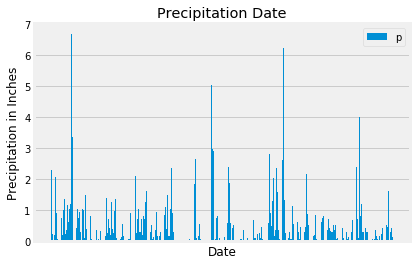

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(precip_df["Date"], precip_df["Precipitation"])
plt.title("Precipitation Date")
plt.xlabel("Date")
plt.ylabel("Precipitation in Inches")
plt.legend("precipitation", loc = "best")
plt.xticks([])
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Declare a query for Stations and the dates
station_query = session.query(Measurement.station, Measurement.date).all()

# First article of each tuple goes to a list "station". The second goes to a list "Counter"
# "Counter" includes a list of dates, but that information will not be used in the .groupby
station_arta = [row[0] for row in station_query]
station_artb = [row[1] for row in station_query]

# Create a Pandas DataFrame with the two lists
activity_df = pd.DataFrame({"Station": station_arta[::], "Counter":station_artb[::]})

# Group the Data by Station.  Then get a count of each station, then sort the rows
# by the number of data points for each station.
activity_df.groupby("Station").count().sort_values(['Counter'], ascending = False)

,Counter
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temp = pd.DataFrame({"Temps":[row[0] for row in session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').all()]})
average = station_temp["Temps"].mean()

temp_sort_top = station_temp.sort_values("Temps", ascending = False)
temp_sort_bot = station_temp.sort_values("Temps", ascending = True)

temp_hot_list = temp_sort_top['Temps'].tolist()
temp_cold_list = temp_sort_bot['Temps'].tolist()

hottest = temp_hot_list[0]
coldest = temp_cold_list[0]

print(average)
print(hottest)
print(coldest)

71.66378066378067
85.0
54.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012FC6557208>]],
      dtype=object)

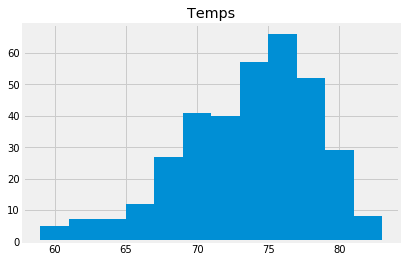

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent_temp = pd.DataFrame({"Temps":[row[0] for row in session.query(Measurement.tobs)\
                                      .filter(Measurement.station == 'USC00519281')\
                                      .filter(Measurement.date > '2016-08-23').all()]})
recent_temp.hist(bins = 12)

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
values = calc_temps('2016-06-04', '2016-06-15')
values

[(65.0, 75.04, 81.0)]

Text(0, 0.5, 'Temperature')

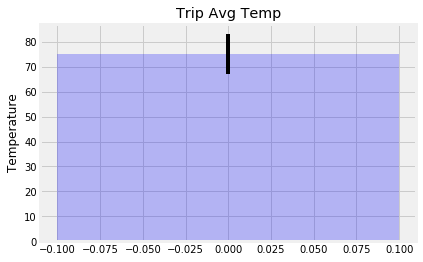

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_axis = np.arange(1)
mean = values[0][1]
yerr = (values[0][2]-values[0][0])/2
plt.bar(x_axis, mean, color='b', alpha=0.25, width = 0.2, align="center", yerr = yerr)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_span = pd.DataFrame({"Station":[row[0] for row in session.query(Measurement.station, Measurement.prcp)\
                                .filter(Measurement.date < '2016-06-15')\
                                .filter(Measurement.date > '2016-06-04').all()],
                          "Precip":[row[1] for row in session.query(Measurement.station, Measurement.prcp)\
                                .filter(Measurement.date < '2016-06-15')\
                                .filter(Measurement.date > '2016-06-04').all()]})
trip_span

,Station,Precip
0,USC00519397,0.00
1,USC00519397,0.00
2,USC00519397,0.01
3,USC00519397,0.00
4,USC00519397,0.01
...,...,...
59,USC00516128,1.40
60,USC00516128,0.65
61,USC00516128,0.55
62,USC00516128,0.08


In [22]:
station_precip = trip_span.groupby("Station").sum()
station_precip

,Precip
Station,
USC00513117,1.86
USC00514830,0.53
USC00516128,6.31
USC00517948,0.00
USC00519281,2.63
USC00519397,0.08
USC00519523,0.98


In [23]:
station_info = pd.DataFrame({"Station":[row[0] for row in session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()],
                         "Name":[row[1] for row in session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()],
                         "Latitude":[row[2] for row in session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()],
                         "Longitude":[row[3] for row in session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()],
                         "Elevation":[row[4] for row in session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()]})
station_info


,Station,Name,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [24]:
merge_station = pd.merge(station_info, station_precip, on = "Station")
merge_station.sort_values(['Precip'], ascending = False)

,Station,Name,Latitude,Longitude,Elevation,Precip
6,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,6.31
5,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.63
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.86
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.98
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.53
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.08
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '06-04-2020'
end_date = '06-15-2020'

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

# The date_list list will include the MM-DD part of the date.
date_list = []
# The full_date list will include the MM-DD-YY part of the date.
full_date = []

# Start the while loop on 'start_date'
date = start_date
# This while loop checks to see if June 15th has been reached.  
while date <= end_date:
    # Change the date to object type "datetime"
    dater = pd.to_datetime(date)
    # Add the MM-DD to date_list as an object type "string"
    date_list.append(dater.strftime("%m-%d"))
    # add the MM-DD-YYYY to full_date
    full_date.append(dater.strftime("%m-%d-%Y"))
    # Add one day to the date
    dater = dater + pd.Timedelta(days=1)
    # Turn the day back into object type "string"
    date = dater.strftime("%m-%d-%Y")
print(date_list)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
# Run the function for all days in the date_list and print their outputs
for day in date_list:
    normals.append(daily_normals(day))
normals

['06-04', '06-05', '06-06', '06-07', '06-08', '06-09', '06-10', '06-11', '06-12', '06-13', '06-14', '06-15']


[[(65.0, 73.81818181818181, 81.0)],
 [(68.0, 74.85454545454546, 81.0)],
 [(70.0, 75.17543859649123, 80.0)],
 [(68.0, 75.07142857142857, 81.0)],
 [(70.0, 75.58620689655173, 81.0)],
 [(69.0, 75.15254237288136, 81.0)],
 [(68.0, 75.14285714285714, 81.0)],
 [(69.0, 76.01960784313725, 84.0)],
 [(66.0, 75.66666666666667, 83.0)],
 [(68.0, 75.66666666666667, 81.0)],
 [(69.0, 75.62711864406779, 81.0)],
 [(67.0, 75.40350877192982, 81.0)]]

In [27]:
# Create a list for the high temps
highs = []
# Create a list for the low temps
lows = []
# Create a list for the average temps
means = []

# Run through the date_list and add the lows, means and highs for each day
for day in date_list:
    lows.append(daily_normals(day)[0][0])
    means.append(daily_normals(day)[0][1])
    highs.append(daily_normals(day)[0][2])

print(lows)
print(means)
print(highs)

[65.0, 68.0, 70.0, 68.0, 70.0, 69.0, 68.0, 69.0, 66.0, 68.0, 69.0, 67.0]
[73.81818181818181, 74.85454545454546, 75.17543859649123, 75.07142857142857, 75.58620689655173, 75.15254237288136, 75.14285714285714, 76.01960784313725, 75.66666666666667, 75.66666666666667, 75.62711864406779, 75.40350877192982]
[81.0, 81.0, 80.0, 81.0, 81.0, 81.0, 81.0, 84.0, 83.0, 81.0, 81.0, 81.0]


In [28]:
# Declare a string that will be appended to the date
year = "-2020"
# Created a list called full_date
full_date = []
# Run a for loop in the date_list
for date in date_list:
    # Create a list of a date in the date_list and the year
    s = pd.Series([date, year])
    # append one of the dates to the year.  You can make this a timedate if you wished.
    full_date.append(s.str.cat(sep=''))
full_date

['06-04-2020',
 '06-05-2020',
 '06-06-2020',
 '06-07-2020',
 '06-08-2020',
 '06-09-2020',
 '06-10-2020',
 '06-11-2020',
 '06-12-2020',
 '06-13-2020',
 '06-14-2020',
 '06-15-2020']

In [29]:
# Create a DataFrame with the Date and the Temperatures
vacay_weather = pd.DataFrame({"Date":full_date, "Lows":lows, "Means":means, "Highs":highs})
vacay_weather

,Date,Lows,Means,Highs
0,06-04-2020,65.0,73.818182,81.0
1,06-05-2020,68.0,74.854545,81.0
2,06-06-2020,70.0,75.175439,80.0
3,06-07-2020,68.0,75.071429,81.0
4,06-08-2020,70.0,75.586207,81.0
5,06-09-2020,69.0,75.152542,81.0
6,06-10-2020,68.0,75.142857,81.0
7,06-11-2020,69.0,76.019608,84.0
8,06-12-2020,66.0,75.666667,83.0
9,06-13-2020,68.0,75.666667,81.0


Text(0, 0.5, 'Temperatures, F')

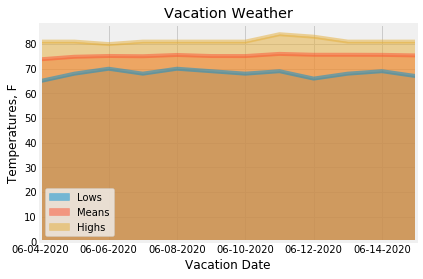

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
vacay_weather.plot(x = "Date", kind = "area", stacked = False)
plt.title("Vacation Weather")
plt.xlabel("Vacation Date")
plt.ylabel("Temperatures, F")